In [4]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models

from PIL import Image
import os
import shutil
import random

from tqdm import tqdm
from utils import to_numpy, show_img


In [12]:
import streamlit
streamlit.__version__

'1.44.1'

## Data Collection

### Download Dataset

In [3]:
! mkdir -p data
! cd data && wget https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
! cd ../

--2025-04-11 09:19:38--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.48.252, 2600:1413:b000:79b::317f, 2600:1413:b000:792::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.36.48.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  11.2MB/s    in 74s     

2025-04-11 09:20:52 (10.7 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



### Unzip the dataset

In [4]:
! cd data && unzip -q kagglecatsanddogs_5340.zip

### Train Test Folder Split (optional)

In [5]:
# INPUT_PATH = 'data/PetImages'


# def split_dataset(input_dir, output_dir, split_ratio=0.8, seed=42):
#     random.seed(seed)
#     classes = ["Cat", "Dog"]

#     for cls in classes:
#         img_dir = os.path.join(input_dir, cls)
#         images = [img for img in os.listdir(img_dir) if img.endswith(".jpg")]
#         random.shuffle(images)

#         split_point = int(len(images) * split_ratio)
#         train_imgs = images[:split_point]
#         test_imgs = images[split_point:]

#         for phase, img_list in [("train", train_imgs), ("test", test_imgs)]:
#             phase_dir = os.path.join(output_dir, phase, cls)
#             os.makedirs(phase_dir, exist_ok=True)

#             for img_name in img_list:
#                 src_path = os.path.join(img_dir, img_name)
#                 dst_path = os.path.join(phase_dir, img_name)
#                 try:
#                     shutil.copyfile(src_path, dst_path)
#                 except:
#                     continue


# split_dataset(input_dir=INPUT_PATH, output_dir='data')

## Data Preprocessing

### Dataset

In [2]:
INPUT_SIZE = 224
CLASSES = ['Cat', 'Dog']

transform_train = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomChoice([
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue = 0.1)
    ]),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])


class CatDogDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.images = []
        self.labels = []
        self.transform = transform
        for label, class_name in enumerate(CLASSES):
            class_dir = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                
                
                if os.path.getsize(image_path) == 0:
                    print(f"Empty file, excluding {image_path}")
                    continue
                
                self.images.append(image_path)
                self.labels.append(label)

                
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path, label = self.images[index], self.labels[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
    
train_dataset = CatDogDataset(root_dir='data/train', transform=transform_train)
test_dataset = CatDogDataset(root_dir='data/test', transform=transform_test)



Empty file, excluding data/train/Cat/666.jpg
Empty file, excluding data/train/Dog/11702.jpg


### Data Exploring

In [6]:
print("Number of training images", len(train_dataset))
print("Number of testing images: ", len(test_dataset))

Number of training images 19998
Number of testing images:  5000


In [7]:
train_labels = np.array(train_dataset.labels)
print("Number of dogs in the train dataset: ", len(train_labels[train_labels == 1]))
print("Number of cats in the train dataset: ", len(train_labels[train_labels==0]))

Number of dogs in the train dataset:  9999
Number of cats in the train dataset:  9999


In [8]:
test_labels = np.array(test_dataset.labels)
print("Number of dogs in the test dataset: ", len(test_labels[test_labels==1]))
print("Number of cats in the test dataset: ", len(test_labels[test_labels==0]))

Number of dogs in the test dataset:  2500
Number of cats in the test dataset:  2500


### DataLoader

In [9]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, num_workers=2, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, num_workers=2, shuffle=True)

### Sample Images

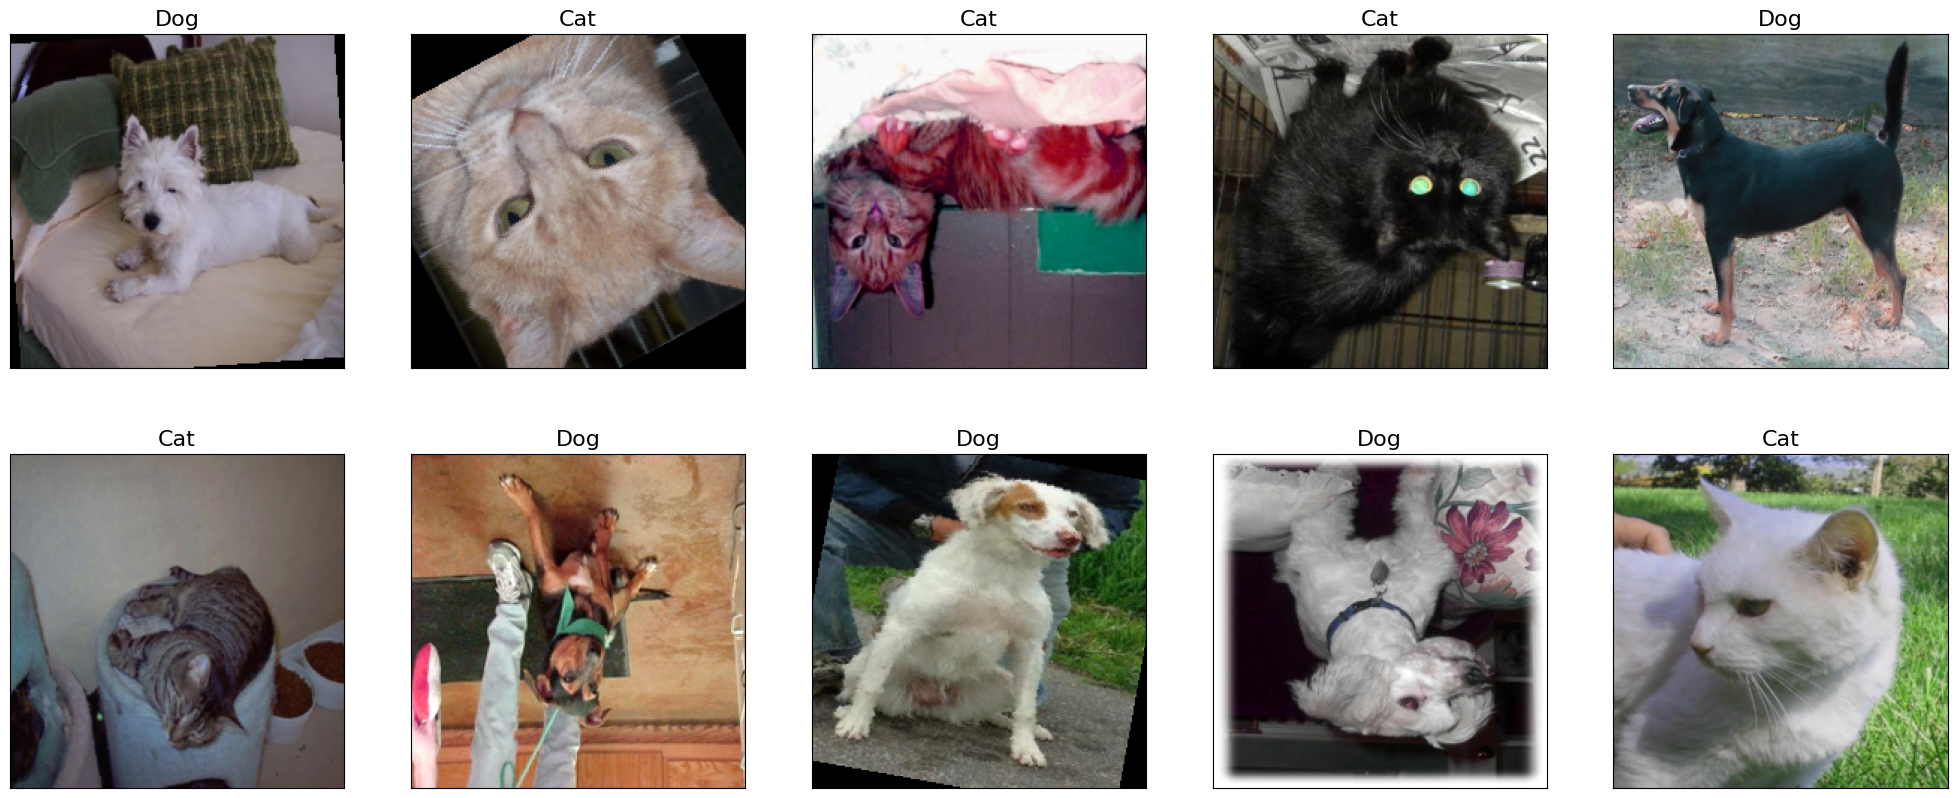

In [11]:

dataiter = iter(train_loader)

images, labels = next(dataiter)
fig = plt.figure(figsize=(25,10))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks = [], yticks = [])
    plt.imshow(to_numpy(images[i]))
    ax.set_title(CLASSES[labels[i].item()], fontsize = 16)


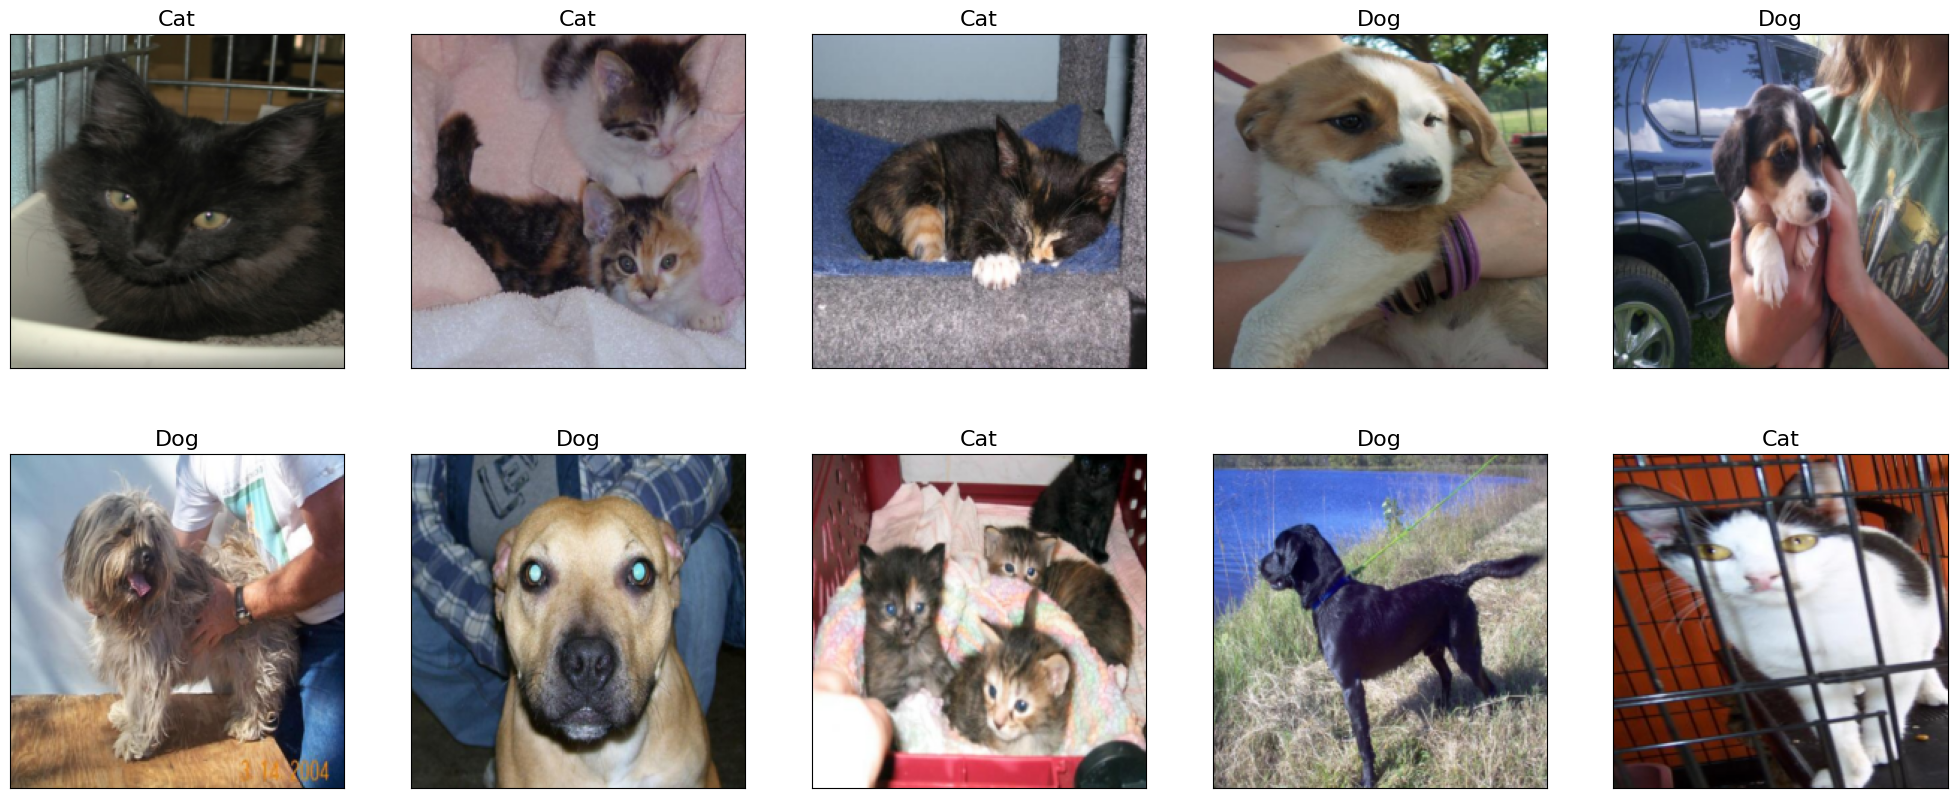

In [12]:
dataiter = iter(test_loader)

images, labels = next(dataiter)
fig = plt.figure(figsize=(25,10))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks = [], yticks = [])
    plt.imshow(to_numpy(images[i]))
    ax.set_title(CLASSES[labels[i].item()], fontsize = 16)

## Define Model

### Setup Device Agnostic Code 

In [3]:
!nvidia-smi 2>&1 | grep -i "cuda"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Training Loop

In [14]:
def train_step(model, train_loader, loss_fn, accuracy_fn, optimizer, device, scheduler = None):

    train_loss, train_acc = 0,0

    model.to(device)
    model.train()
    train_data = tqdm(train_loader, leave=True, desc="Training")

    for X_train, y_train in train_data:
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_logits = model(X_train)
        y_pred = y_logits.argmax(dim=1)

        loss = loss_fn(y_logits, y_train)

        train_loss += loss.item()
        train_acc += accuracy_fn(y_train, y_pred)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    if scheduler:
        scheduler.step()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%\n")
    return train_loss, train_acc


def test_step(model, test_loader, loss_fn, accuracy_fn, device):
    model.to(device)
    model.eval()

    test_loss, test_acc = 0.0, 0.0
    test_data = tqdm(test_loader, leave=True, desc="Testing")

    with torch.inference_mode():
        for X_test, y_test in test_data:
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_logits = model(X_test)
            test_pred = test_logits.argmax(dim=1)

            test_loss += loss_fn(test_logits, y_test).item()
            test_acc += accuracy_fn(y_test, test_pred)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")
    return test_loss, test_acc



def train_model(model, train_loader, test_loader, loss_fn, accuracy_fn, optimizer, device, scheduler = None, epochs=3):
    model_results = {
        'train_loss' : [],
        'train_acc' : [],
        'test_loss' : [],
        'test_acc' : []
    }
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}:")
        train_loss, train_acc = train_step(model, train_loader, loss_fn, accuracy_fn, optimizer, device, scheduler)
        test_loss, test_acc = test_step(model, test_loader, loss_fn, accuracy_fn, device)
        model_results['train_loss'].append(train_loss)
        model_results['train_acc'].append(train_acc)
        model_results['test_loss'].append(test_loss)
        model_results['test_acc'].append(test_acc)
    return model_results

def accuracy_function(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_true)) * 100

### Self-defined Model

In [15]:
MODEL_INPUT_SIZE = 256
MODEL_OUTPUT_SIZE = len(CLASSES)

class CatDogModel(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_shape = 64):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=3, padding=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, stride=3, padding=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=7, stride=3, padding=3),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_shape),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(in_features=hidden_shape, out_features=output_shape)
        )
    
    def forward(self, X):
        return self.fc_layer(self.conv_layer(X))


In [16]:
model_0 = CatDogModel(input_shape=MODEL_INPUT_SIZE, output_shape=MODEL_OUTPUT_SIZE, hidden_shape=64)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.001)

In [17]:
model_0_results = train_model(model=model_0, train_loader=train_loader, test_loader=test_loader, loss_fn=criterion, accuracy_fn=accuracy_function, optimizer=optimizer, device=device, epochs=10)


Epoch 1/10:


Training: 100%|██████████| 313/313 [01:17<00:00,  4.02it/s]


Train loss: 0.63955 | Train accuracy: 63.43%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


Test Loss: 0.69387 | Test Accuracy: 59.39%


Epoch 2/10:


Training: 100%|██████████| 313/313 [01:18<00:00,  3.98it/s]


Train loss: 0.58539 | Train accuracy: 68.96%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.33it/s]


Test Loss: 0.60654 | Test Accuracy: 65.45%


Epoch 3/10:


Training: 100%|██████████| 313/313 [01:17<00:00,  4.02it/s]


Train loss: 0.54622 | Train accuracy: 72.39%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.13it/s]


Test Loss: 0.51962 | Test Accuracy: 72.51%


Epoch 4/10:


Training: 100%|██████████| 313/313 [01:17<00:00,  4.03it/s]


Train loss: 0.52054 | Train accuracy: 74.52%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.40it/s]


Test Loss: 0.53624 | Test Accuracy: 72.57%


Epoch 5/10:


Training: 100%|██████████| 313/313 [01:17<00:00,  4.05it/s]


Train loss: 0.49863 | Train accuracy: 75.77%



Testing: 100%|██████████| 79/79 [00:13<00:00,  5.87it/s]


Test Loss: 0.46974 | Test Accuracy: 77.31%


Epoch 6/10:


Training: 100%|██████████| 313/313 [01:17<00:00,  4.01it/s]


Train loss: 0.48406 | Train accuracy: 76.83%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Test Loss: 0.47571 | Test Accuracy: 78.36%


Epoch 7/10:


Training: 100%|██████████| 313/313 [01:18<00:00,  3.99it/s]


Train loss: 0.46739 | Train accuracy: 78.29%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.40it/s]


Test Loss: 0.45779 | Test Accuracy: 77.87%


Epoch 8/10:


Training: 100%|██████████| 313/313 [01:19<00:00,  3.95it/s]


Train loss: 0.45542 | Train accuracy: 78.68%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Loss: 0.40829 | Test Accuracy: 81.69%


Epoch 9/10:


Training: 100%|██████████| 313/313 [01:18<00:00,  4.00it/s]


Train loss: 0.43998 | Train accuracy: 79.71%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.18it/s]


Test Loss: 0.43197 | Test Accuracy: 79.19%


Epoch 10/10:


Training: 100%|██████████| 313/313 [01:17<00:00,  4.05it/s]


Train loss: 0.43468 | Train accuracy: 80.10%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.39it/s]

Test Loss: 0.41304 | Test Accuracy: 81.25%



In [44]:
result_df = pd.DataFrame(model_0_results)
result_df['epoch'] = np.arange(1,11)
result_df


train_loss  train_acc  test_loss   test_acc  epoch
0    0.639552  63.427516   0.693871  59.394778      1
1    0.585389  68.958001   0.606537  65.446994      2
2    0.546220  72.388179   0.519623  72.507911      3
3    0.520541  74.516108   0.536238  72.567247      4
4    0.498628  75.771100   0.469740  77.314082      5
5    0.484061  76.831070   0.475710  78.362342      6
6    0.467394  78.290735   0.457786  77.867880      7
7    0.455417  78.675120   0.408288  81.685127      8
8    0.439978  79.712793   0.431965  79.193038      9
9    0.434684  80.097843   0.413039  81.250000     10

In [19]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

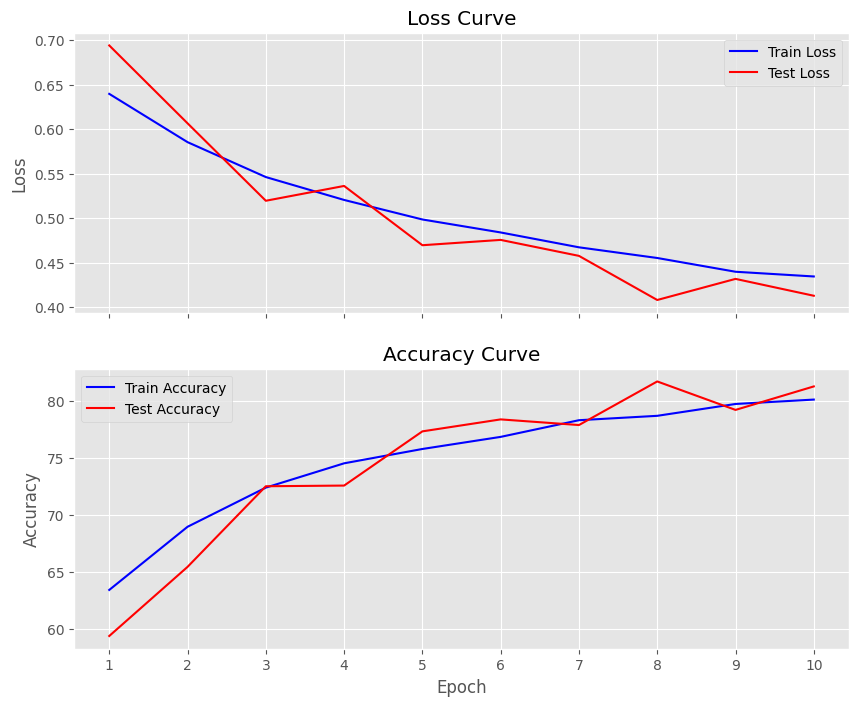

In [45]:
plt.style.use('ggplot')
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

sns.lineplot(data=result_df, x='epoch', y='train_loss', color='blue', label='Train Loss', ax=axs[0])
sns.lineplot(data=result_df, x='epoch', y='test_loss', color='red', label='Test Loss', ax=axs[0])
axs[0].set_title("Loss Curve")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].set_xticks(result_df['epoch'])

sns.lineplot(data=result_df, x='epoch', y='train_acc', color='blue', label='Train Accuracy', ax=axs[1])
sns.lineplot(data=result_df, x='epoch', y='test_acc', color='red', label='Test Accuracy', ax=axs[1])
axs[1].set_title("Accuracy Curve")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].set_xticks(result_df['epoch'])

plt.show()

#### Save Model State Dict

In [21]:
!mkdir models


In [23]:
torch.save(model_0.state_dict(), 'models/CatDogModel_0.pth')

### ResNet 18

#### Get Model

In [51]:
resnet_model = models.resnet18()

#### Modify Output Layer

In [52]:
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Train Model

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [54]:
resnet_results = train_model(model=resnet_model, train_loader=train_loader, test_loader=test_loader, loss_fn=criterion, accuracy_fn=accuracy_function, optimizer=optimizer, device = device, scheduler=scheduler, epochs=10)


Epoch 1/10:


Training:  20%|█▉        | 62/313 [00:18<01:27,  2.88it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Training: 100%|██████████| 313/313 [01:29<00:00,  3.49it/s]


Train loss: 0.67402 | Train accuracy: 60.44%



Testing: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Test Loss: 0.64113 | Test Accuracy: 62.94%


Epoch 2/10:


Training:  19%|█▉        | 61/313 [00:16<01:13,  3.43it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Training: 100%|██████████| 313/313 [01:24<00:00,  3.71it/s]


Train loss: 0.60566 | Train accuracy: 67.33%



Testing: 100%|██████████| 79/79 [00:13<00:00,  6.02it/s]


Test Loss: 0.68629 | Test Accuracy: 60.56%


Epoch 3/10:


Training:   4%|▍         | 14/313 [00:04<01:17,  3.87it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Training: 100%|██████████| 313/313 [01:22<00:00,  3.79it/s]


Train loss: 0.54615 | Train accuracy: 72.31%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.26it/s]


Test Loss: 0.58878 | Test Accuracy: 71.91%


Epoch 4/10:


Training:  19%|█▉        | 60/313 [00:16<01:00,  4.16it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Training: 100%|██████████| 313/313 [01:21<00:00,  3.85it/s]


Train loss: 0.49057 | Train accuracy: 76.56%



Testing: 100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


Test Loss: 0.68369 | Test Accuracy: 64.77%


Epoch 5/10:


Training:  32%|███▏      | 100/313 [00:26<00:49,  4.34it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Training: 100%|██████████| 313/313 [01:23<00:00,  3.76it/s]


Train loss: 0.44044 | Train accuracy: 79.63%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.09it/s]


Test Loss: 0.68241 | Test Accuracy: 68.67%


Epoch 6/10:


Training:  70%|███████   | 220/313 [00:58<00:23,  3.92it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Training: 100%|██████████| 313/313 [01:23<00:00,  3.76it/s]


Train loss: 0.40727 | Train accuracy: 81.47%



Testing: 100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


Test Loss: 0.57998 | Test Accuracy: 75.30%


Epoch 7/10:


Training:   6%|▌         | 19/313 [00:05<01:17,  3.78it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Training: 100%|██████████| 313/313 [01:23<00:00,  3.77it/s]


Train loss: 0.37242 | Train accuracy: 83.45%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Test Loss: 0.38178 | Test Accuracy: 82.69%


Epoch 8/10:


Training:  55%|█████▍    | 172/313 [00:45<00:33,  4.21it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Training: 100%|██████████| 313/313 [01:22<00:00,  3.79it/s]


Train loss: 0.35484 | Train accuracy: 84.00%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


Test Loss: 0.31878 | Test Accuracy: 86.43%


Epoch 9/10:


Training:  86%|████████▌ | 269/313 [01:11<00:12,  3.45it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Training: 100%|██████████| 313/313 [01:23<00:00,  3.76it/s]


Train loss: 0.32843 | Train accuracy: 85.63%



Testing: 100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Loss: 0.30271 | Test Accuracy: 86.81%


Epoch 10/10:


Training:  69%|██████▉   | 216/313 [00:58<00:24,  3.99it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Training: 100%|██████████| 313/313 [01:23<00:00,  3.73it/s]


Train loss: 0.30438 | Train accuracy: 86.57%



Testing: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]

Test Loss: 0.33825 | Test Accuracy: 84.85%



#### Evauluation

In [55]:
result_df = pd.DataFrame(resnet_results)
result_df['epoch'] = np.arange(1,11)
result_df

train_loss  train_acc  test_loss   test_acc  epoch
0    0.674020  60.441627   0.641128  62.935127      1
1    0.605664  67.333600   0.686287  60.561709      2
2    0.546150  72.308307   0.588785  71.914557      3
3    0.490575  76.560836   0.683692  64.774525      4
4    0.440436  79.630591   0.682411  68.670886      5
5    0.407270  81.469316   0.579980  75.296677      6
6    0.372417  83.454473   0.381781  82.693829      7
7    0.354845  84.001597   0.318775  86.431962      8
8    0.328430  85.629659   0.302706  86.807753      9
9    0.304383  86.570820   0.338253  84.849684     10

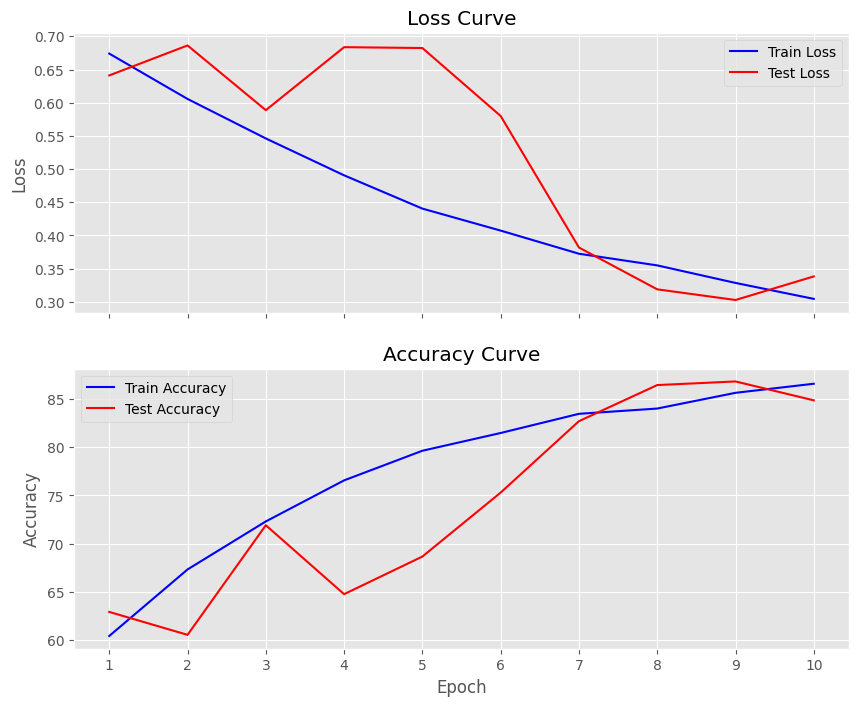

In [56]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

sns.lineplot(data=result_df, x='epoch', y='train_loss', color='blue', label='Train Loss', ax=axs[0])
sns.lineplot(data=result_df, x='epoch', y='test_loss', color='red', label='Test Loss', ax=axs[0])
axs[0].set_title("Loss Curve")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].set_xticks(result_df['epoch'])

sns.lineplot(data=result_df, x='epoch', y='train_acc', color='blue', label='Train Accuracy', ax=axs[1])
sns.lineplot(data=result_df, x='epoch', y='test_acc', color='red', label='Test Accuracy', ax=axs[1])
axs[1].set_title("Accuracy Curve")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].set_xticks(result_df['epoch'])

plt.show()

#### Save Model's State Dict

In [57]:
torch.save(resnet_model.state_dict(), 'models/CatDog_ResNet18.pth')

### ResNet 50 Transfer Learning

### Get Model

In [24]:
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s] 


#### Modify Output Layer

In [37]:
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Train Model

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [39]:
resnet_results = train_model(model=resnet_model, train_loader=train_loader, test_loader=test_loader, loss_fn=criterion, accuracy_fn=accuracy_function, optimizer=optimizer, device = device, scheduler=scheduler, epochs=10)


Epoch 1/10:


Training: 100%|██████████| 313/313 [03:19<00:00,  1.57it/s]


Train loss: 0.17496 | Train accuracy: 93.23%



Testing: 100%|██████████| 79/79 [00:16<00:00,  4.66it/s]


Test Loss: 0.13125 | Test Accuracy: 95.09%


Epoch 2/10:


Training: 100%|██████████| 313/313 [03:20<00:00,  1.56it/s]


Train loss: 0.13299 | Train accuracy: 94.68%



Testing: 100%|██████████| 79/79 [00:16<00:00,  4.69it/s]


Test Loss: 0.53887 | Test Accuracy: 83.84%


Epoch 3/10:


Training: 100%|██████████| 313/313 [03:20<00:00,  1.56it/s]


Train loss: 0.11960 | Train accuracy: 95.31%



Testing: 100%|██████████| 79/79 [00:16<00:00,  4.65it/s]


Test Loss: 0.11445 | Test Accuracy: 95.39%


Epoch 4/10:


Training: 100%|██████████| 313/313 [03:20<00:00,  1.56it/s]


Train loss: 0.12114 | Train accuracy: 95.22%



Testing: 100%|██████████| 79/79 [00:16<00:00,  4.68it/s]


Test Loss: 0.10461 | Test Accuracy: 95.61%


Epoch 5/10:


Training: 100%|██████████| 313/313 [03:20<00:00,  1.56it/s]


Train loss: 0.11511 | Train accuracy: 95.47%



Testing: 100%|██████████| 79/79 [00:16<00:00,  4.70it/s]


Test Loss: 0.09994 | Test Accuracy: 95.53%


Epoch 6/10:


Training: 100%|██████████| 313/313 [03:20<00:00,  1.56it/s]


Train loss: 0.10789 | Train accuracy: 95.66%



Testing: 100%|██████████| 79/79 [00:16<00:00,  4.69it/s]


Test Loss: 0.10883 | Test Accuracy: 95.77%


Epoch 7/10:


Training: 100%|██████████| 313/313 [03:20<00:00,  1.56it/s]


Train loss: 0.11193 | Train accuracy: 95.59%



Testing: 100%|██████████| 79/79 [00:16<00:00,  4.70it/s]


Test Loss: 0.08728 | Test Accuracy: 96.32%


Epoch 8/10:


Training: 100%|██████████| 313/313 [03:20<00:00,  1.56it/s]


Train loss: 0.10660 | Train accuracy: 95.67%



Testing: 100%|██████████| 79/79 [00:16<00:00,  4.71it/s]


Test Loss: 0.11277 | Test Accuracy: 95.27%


Epoch 9/10:


Training: 100%|██████████| 313/313 [03:20<00:00,  1.56it/s]


Train loss: 0.11013 | Train accuracy: 95.63%



Testing: 100%|██████████| 79/79 [00:16<00:00,  4.67it/s]


Test Loss: 0.14790 | Test Accuracy: 94.72%


Epoch 10/10:


Training: 100%|██████████| 313/313 [03:20<00:00,  1.56it/s]


Train loss: 0.10728 | Train accuracy: 95.73%



Testing: 100%|██████████| 79/79 [00:16<00:00,  4.70it/s]

Test Loss: 0.10332 | Test Accuracy: 96.00%



#### Evaluation

In [46]:
result_df = pd.DataFrame(resnet_results)
result_df['epoch'] = np.arange(1,11)
result_df

train_loss  train_acc  test_loss   test_acc  epoch
0    0.174962  93.230165   0.131252  95.094937      1
1    0.132993  94.682841   0.538866  83.840981      2
2    0.119601  95.310503   0.114445  95.391614      3
3    0.121143  95.221978   0.104614  95.609177      4
4    0.115109  95.471579   0.099937  95.530063      5
5    0.107888  95.656949   0.108831  95.767405      6
6    0.111933  95.586395   0.087277  96.321203      7
7    0.106599  95.666267   0.112768  95.272943      8
8    0.110130  95.626997   0.147905  94.719146      9
9    0.107284  95.726171   0.103315  96.004747     10

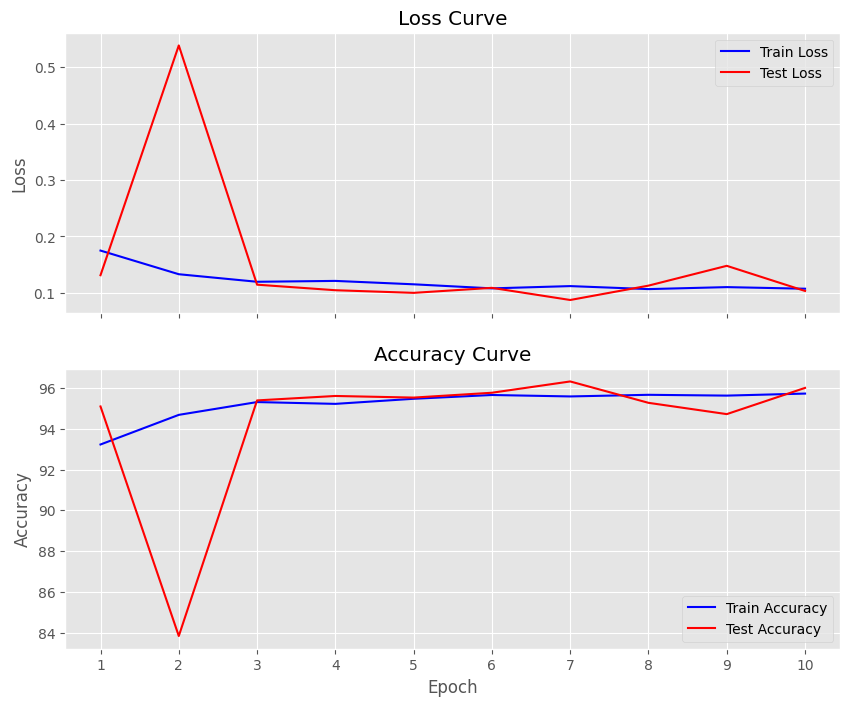

In [47]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

sns.lineplot(data=result_df, x='epoch', y='train_loss', color='blue', label='Train Loss', ax=axs[0])
sns.lineplot(data=result_df, x='epoch', y='test_loss', color='red', label='Test Loss', ax=axs[0])
axs[0].set_title("Loss Curve")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].set_xticks(result_df['epoch'])

sns.lineplot(data=result_df, x='epoch', y='train_acc', color='blue', label='Train Accuracy', ax=axs[1])
sns.lineplot(data=result_df, x='epoch', y='test_acc', color='red', label='Test Accuracy', ax=axs[1])
axs[1].set_title("Accuracy Curve")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].set_xticks(result_df['epoch'])

plt.show()

#### Save Model State Dict

In [48]:
torch.save(resnet_model.state_dict(), 'models/CatDog_ResNet50.pth')